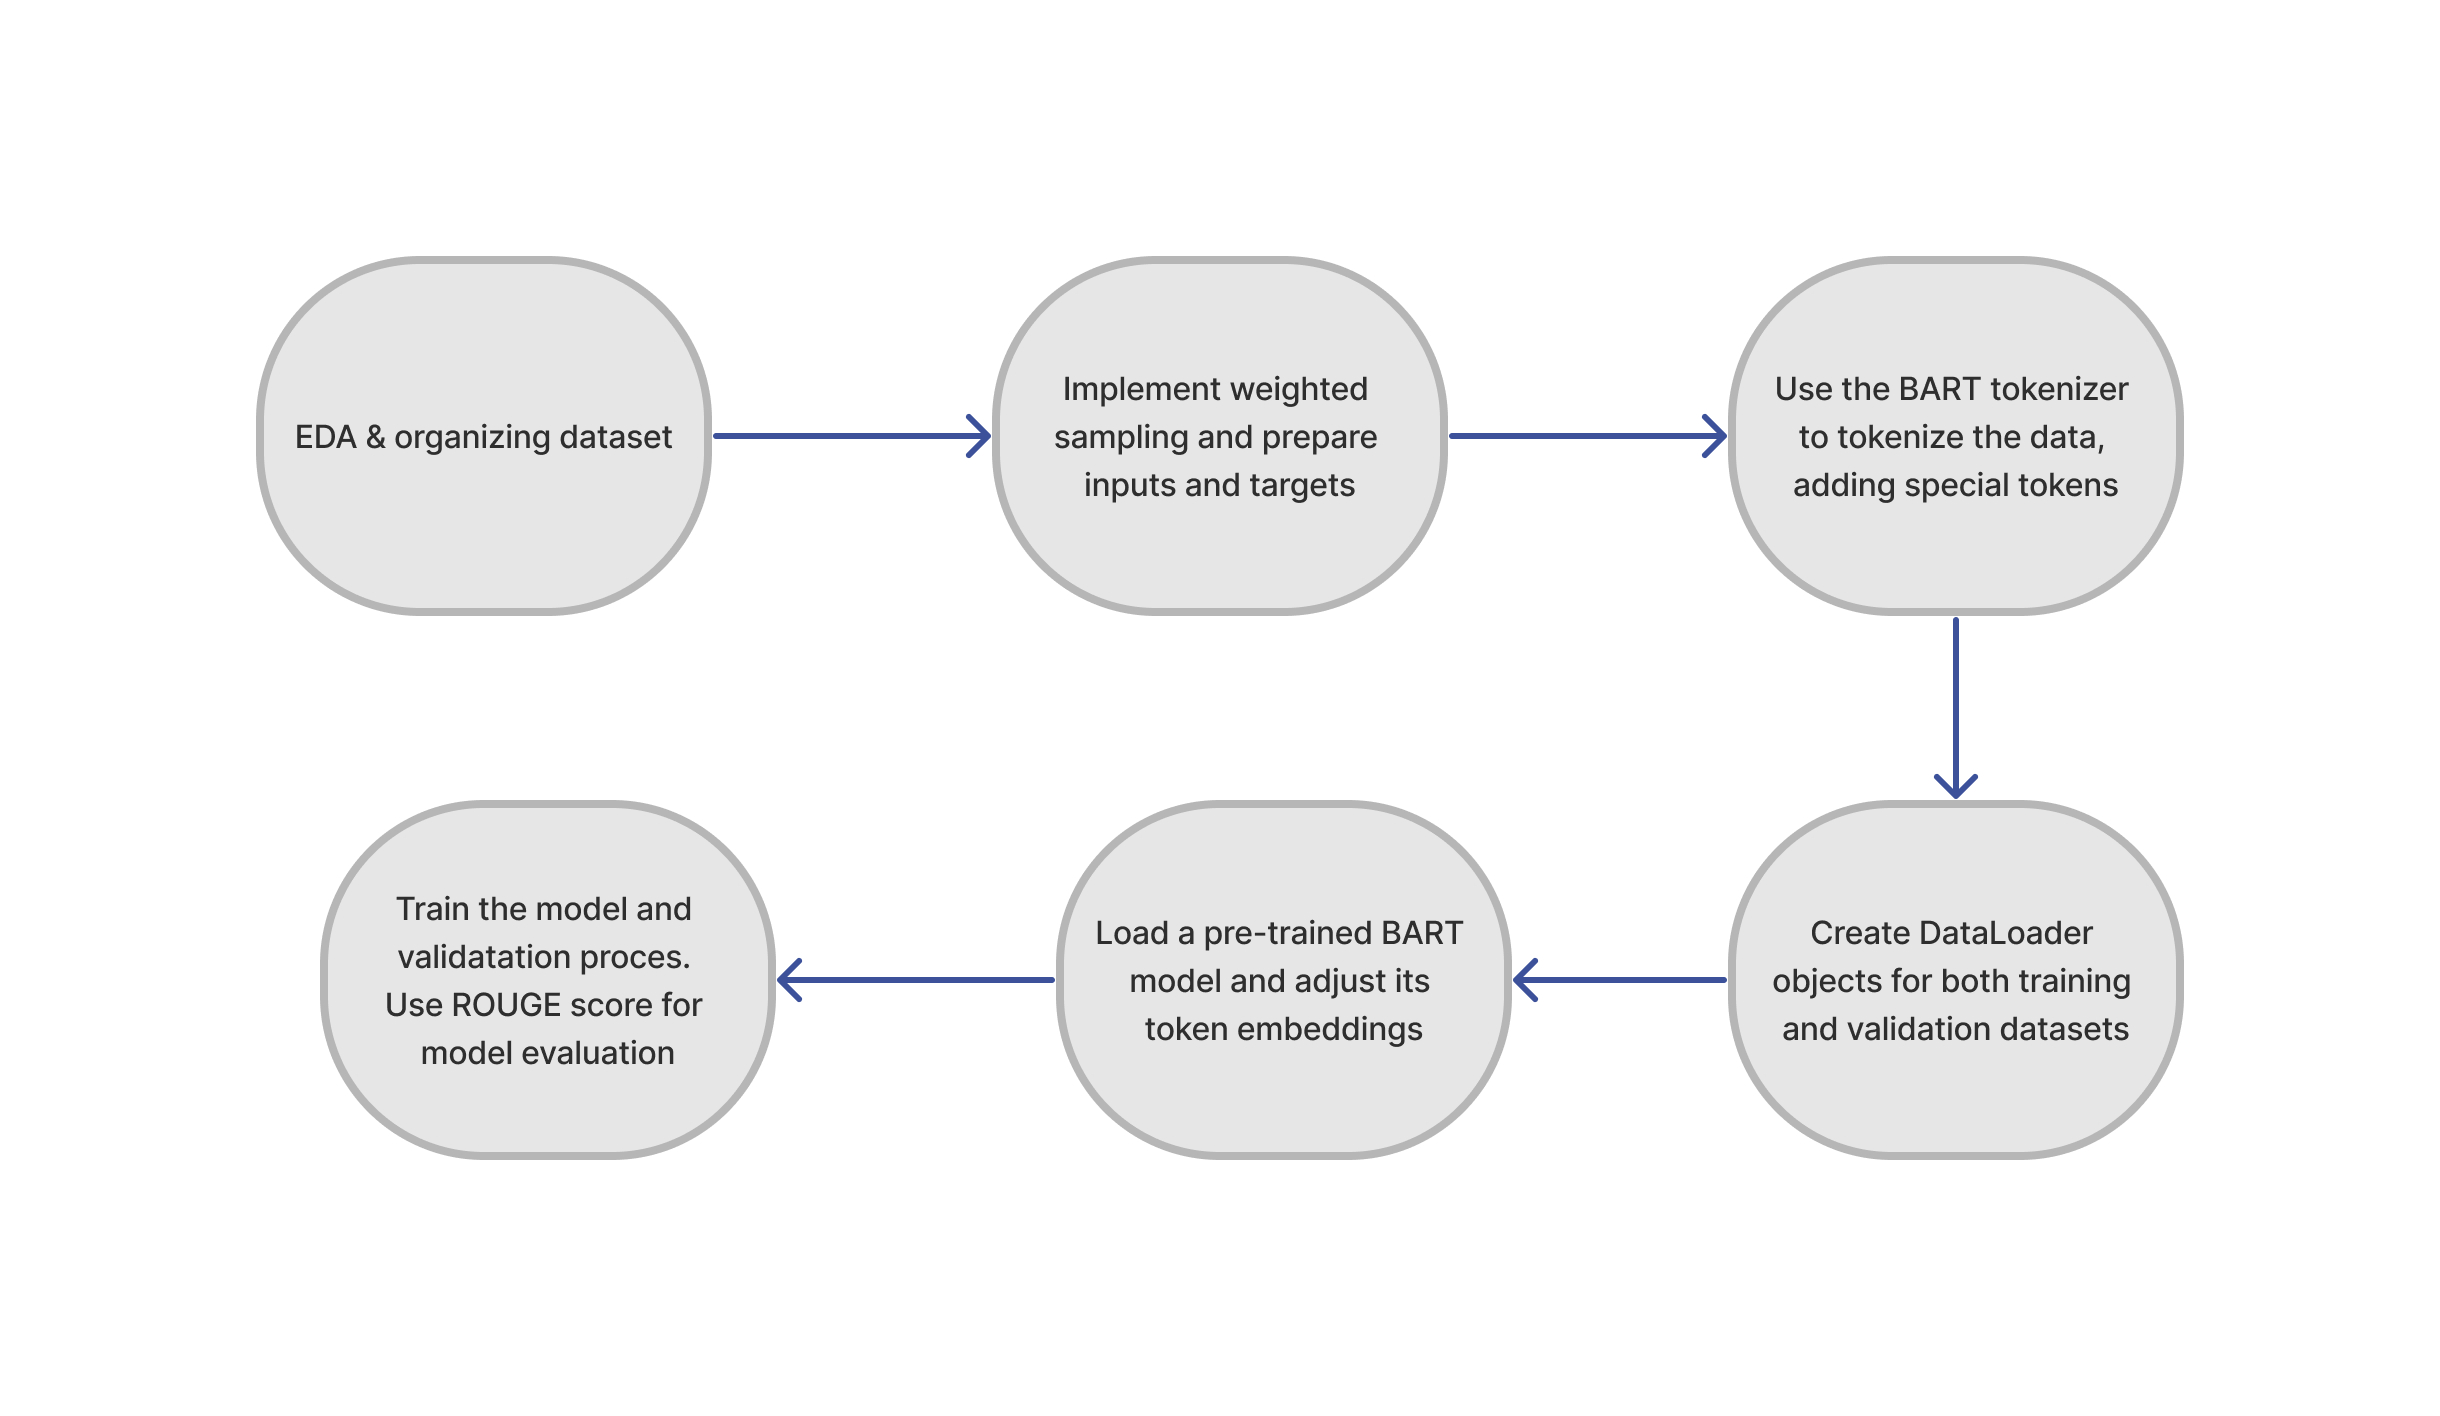

# **Step1: Install and Import libraries**

In [ ]:
!pip install -qq datasets
!pip install -qq rouge-score datasets

from datasets import load_dataset, load_metric
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments, AdamW
from tqdm import tqdm
import numpy as np
import torch
from transformers import Trainer, TrainingArguments
import os

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#**Step 2: Data Loading**

In [ ]:
dataset = load_dataset("eli5_category")
dataset

/opt/conda/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for eli5_category contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/eli5_category
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/91772 [00:00<?, ? examples/s]

Generating validation1 split:   0%|          | 0/5446 [00:00<?, ? examples/s]

Generating validation2 split:   0%|          | 0/2375 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5411 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['q_id', 'title', 'selftext', 'category', 'subreddit', 'answers', 'title_urls', 'selftext_urls'],
        num_rows: 91772
    })
    validation1: Dataset({
        features: ['q_id', 'title', 'selftext', 'category', 'subreddit', 'answers', 'title_urls', 'selftext_urls'],
        num_rows: 5446
    })
    validation2: Dataset({
        features: ['q_id', 'title', 'selftext', 'category', 'subreddit', 'answers', 'title_urls', 'selftext_urls'],
        num_rows: 2375
    })
    test: Dataset({
        features: ['q_id', 'title', 'selftext', 'category', 'subreddit', 'answers', 'title_urls', 'selftext_urls'],
        num_rows: 5411
    })
})

## 2-1 Prepare dataset to train

In [ ]:
def organize_dataset(data):
    questions = []
    answers_list = []
    scores_list = []

    for item in data:
        answers = item['answers']['text']
        scores = item['answers'].get('score', [])

        questions.append(item['title'])
        answers_list.append(answers)
        scores_list.append(scores)
    return {
        "questions": questions,
        "answers": answers_list,
        "scores": scores_list
    }

## 2-2 Weighted_sampling

In [ ]:
# Define weighted sampling function
def weighted_sample(answers, scores, k=3):
    k = min(k, len(answers))

    if len(answers) == 0:
        return []

    total_score = sum(scores)
    probabilities = [score / total_score for score in scores]
    sampled_indices = np.random.choice(len(answers), size=k, replace=False, p=probabilities)
    return [answers[i] for i in sampled_indices]

In [ ]:
# Prepare the dataset for training
def prepare_dataset(data):
    inputs = []
    targets = []
    for question, answers, scores in zip(data["questions"], data["answers"], data["scores"]):

        sampled_answers = weighted_sample(answers, scores)
        combined_sampled_answers = " ".join(sampled_answers)
        input_text = f"explain this question: {question} context: {combined_sampled_answers}"
        target_text = " ".join(sampled_answers)
        inputs.append(input_text)
        targets.append(target_text)

    return inputs, targets

## 2-3 Train-Validation Split

In [ ]:
train_data = organize_dataset(dataset["train"])
validation_data = organize_dataset(dataset["validation1"])
small_train_data = {key: value[:10000] for key, value in train_data.items()}
small_validation_data = {key: value[:500] for key, value in validation_data.items()}
train_inputs, train_targets = prepare_dataset(small_train_data)
validation_inputs, validation_targets = prepare_dataset(small_validation_data)

# **Step 3: Tokenization and DataLoader**

In [ ]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large').to(device)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## 3-1 Add Special tokens

In [ ]:
special_tokens_dict = {'additional_special_tokens': ['<ans_start>', '<ans_end>']}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))  # Adjust model's token embeddings to accommodate new tokens

Embedding(50267, 1024)

## 3-2 Tokenization

In [ ]:
def tokenize_with_encode_plus(inputs, targets, tokenizer, max_length=512):

    encodings = {'input_ids': [], 'attention_mask': [], 'labels': []}

    # Adding special tokens manually for clarity
    ans_start_token = "<ans_start>"
    ans_end_token = "<ans_end>"

    for input_text, target_text in zip(inputs, targets):
        # Prepend and append the special tokens to the target text
        modified_target_text = f"{ans_start_token} {target_text} {ans_end_token}"

        input_tokens = tokenizer.encode_plus(
            input_text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        target_tokens = tokenizer.encode_plus(
            modified_target_text,
            add_special_tokens=True,  # This will also include the tokenizer's default special tokens
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        encodings['input_ids'].append(input_tokens['input_ids'])
        encodings['attention_mask'].append(input_tokens['attention_mask'])
        encodings['labels'].append(target_tokens['input_ids'])

    # Concatenate lists of tensors into a single tensor
    encodings['input_ids'] = torch.cat(encodings['input_ids'], dim=0)
    encodings['attention_mask'] = torch.cat(encodings['attention_mask'], dim=0)
    encodings['labels'] = torch.cat(encodings['labels'], dim=0)

    return encodings

    if len(encodings['input_ids']) == 1:  # Example print out for the first batch
        print("Example of tokenized input:", tokenizer.convert_ids_to_tokens(input_tokens['input_ids'][0]))
        print("Example of tokenized target:", tokenizer.convert_ids_to_tokens(target_tokens['input_ids'][0]))

## 3-3 DataLoader

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
def prepare_dataloader(inputs, targets, tokenizer, batch_size=8, max_length=512):
    encodings = tokenize_with_encode_plus(inputs, targets, tokenizer, max_length)
    dataset = CustomDataset(encodings)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader



train_dataloader = prepare_dataloader(train_inputs, train_targets, tokenizer, batch_size=2)
validation_dataloader = prepare_dataloader(validation_inputs, validation_targets, tokenizer, batch_size=2)

In [ ]:
def test_dataloader(dataloader):
    for i, batch in enumerate(dataloader):
        print(f"Batch {i + 1}")
        print("Input IDs:", batch['input_ids'].shape)
        print(batch['input_ids'])
        print("Attention Mask:", batch['attention_mask'].shape)
        print(batch['attention_mask'])
        print("Labels:", batch['labels'].shape)
        print(batch['labels'])
        print("Input Text Example:", tokenizer.decode(batch['input_ids'][0]))
        print("Label Text Example:", tokenizer.decode(batch['labels'][0]))
        if i >= 1:
            break


test_dataloader(train_dataloader)

# **Step 4: Train and Validate**

##4-1 Load Rouge

In [ ]:
rouge = load_metric('rouge')

def compute_rouge(predictions, references):
    return rouge.compute(predictions=predictions, references=references)


/tmp/ipykernel_25/138901168.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric('rouge')
/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


## 4-2 Train and Validate

In [ ]:
def train_and_validate(model, train_dataloader, validation_dataloader, tokenizer, optimizer, num_epochs=3, device='cuda', checkpoint_dir='checkpoints'):
    model.to(device)
    os.makedirs(checkpoint_dir, exist_ok=True)
    rouge = load_metric('rouge')

    results = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_val_loss = 0

        # Training phase
        for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Checkpointing after each epoch
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
        torch.save(model.state_dict(), checkpoint_path)

        # Validation phase
        model.eval()
        predictions = []
        references = []
        with torch.no_grad():
            for batch in tqdm(validation_dataloader, desc=f"Validation Epoch {epoch + 1}"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model.generate(input_ids, attention_mask=attention_mask, max_length=512, num_beams=5, early_stopping=True)
                decoded_preds = [tokenizer.decode(gid, skip_special_tokens=True) for gid in outputs]
                decoded_labels = [tokenizer.decode(lid, skip_special_tokens=True) for lid in labels.cpu().numpy()]

                predictions.extend(decoded_preds)
                references.extend(decoded_labels)

#                 val_loss = outputs.loss.mean().item()  # Assumes 'loss' is returned in generate; adjust as needed
#                 total_val_loss += val_loss


        rouge_results = rouge.compute(predictions=predictions, references=references)

        # Extract a few needed results from ROUGE
        rouge1 = rouge_results['rouge1'].mid.fmeasure
        rouge2 = rouge_results['rouge2'].mid.fmeasure
        rougeL = rouge_results['rougeL'].mid.fmeasure


        results.append({
            "Epoch": epoch + 1,
            "Training Loss": total_loss / len(train_dataloader),
            "Validation Loss": total_val_loss / len(validation_dataloader),
            "ROUGE-1": rouge1,
            "ROUGE-2": rouge2,
            "ROUGE-L": rougeL
        })


    results_df = pd.DataFrame(results)
    print(results_df)

    return model



In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)

train_and_validate(model, train_dataloader, validation_dataloader, tokenizer, optimizer, num_epochs=3, device='cuda', checkpoint_dir='checkpoints')


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
Validation Epoch 3: 100%|██████████| 250/250 [55:31<00:00, 13.33s/it]


   Epoch  Training Loss  Validation Loss   ROUGE-1   ROUGE-2   ROUGE-L
0      1       3.122547              0.0  0.247136  0.003855  0.092680
1      2       3.741816              0.0  0.246812  0.001977  0.093557
2      3       3.584353              0.0  0.255596  0.002633  0.094907


BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50267, 1024)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50267, 1024)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((1024,), eps=1e-05, el

# **Step 5: Test Model**

In [ ]:
def generate_answers(model, tokenizer, questions, max_length=512, num_beams=5):
    model.eval()
    generated_answers = []

    for question in questions:
        inputs = tokenizer.encode_plus(question, return_tensors="pt", max_length=max_length, truncation=True, padding="max_length", add_special_tokens=True).to(device)
        outputs = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=max_length, num_beams=num_beams, early_stopping=True)
        generated_answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated_answers.append(generated_answer)

    return generated_answers

In [ ]:
test_data = organize_dataset(dataset["validation2"])
small_test_data = {key: value[:2] for key, value in test_data.items()}
q = small_test_data['questions'][0]
query = f'explain this question:{q}'
sample_answers = generate_answers(model, tokenizer, query , max_length=512, num_beams=5)
predicted_answer = sample_answers[0]
print(f"Question: {query}")
print(f"Predicted Answer: {predicted_answer}")


Question: explain this question:why does stretching feel good?
Predicted Answer:  It It The The They They Because Because There There is is I I When When the the's's You You Your Your are are a a of of This This,, A A In In you you it it Yes Yes If If't't We We Well Well That That Some Some to to.. don don have have Basically Basically can can Generally Generally What What think think Not Not Most Most not not in in Humans Humans No No " " they they Its Its Think Think that that Water Water body body People People For For So So do do Our Our're're has has One One As As My My > > doesn doesn First First Usually Usually your your and and'm'm actually actually because because Many Many Sound Sound Two Two an an Blood Blood Part Part air air Imagine Imagine question question water water To To Both Both Actually Actually From From isn


# **Step 6: Save the Model**

In [ ]:
model.save_pretrained('/kaggle/working/my_bart_model')
tokenizer.save_pretrained('/kaggle/working/my_bart_model')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('/kaggle/working/my_bart_model/tokenizer_config.json',
 '/kaggle/working/my_bart_model/special_tokens_map.json',
 '/kaggle/working/my_bart_model/vocab.json',
 '/kaggle/working/my_bart_model/merges.txt',
 '/kaggle/working/my_bart_model/added_tokens.json')